In [79]:
import numpy as np
import pandas as pd
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from ClassificadorAlfa import ClassificadorAlfa
warnings.filterwarnings('ignore')

In [80]:
df = pd.read_csv(os.path.join('data', 'healthcare-dataset-stroke-data.csv'))

## Hipótese 1

Para a hipótese 1, vamos testar todos os dados contidos no DataFrame, sem alterações, porém apenas os dados que podem ser tratados como Booleanos. Vamos utilizar as variáveis categóricas para realizar o teste. A hipótese nula, no caso, seria montar um classificador que irá sempre prever os dados como sendo o mais frequente $(x)$, ou seja, será a acurácia medida ao dividir tal valor pelo total dos dados contidos no DataFrame $(N)$:

$$
Acurácia = \frac{x}{N}
$$

Portanto, vamos calcular, ao final, a acurácia da hipótese nula e verificar como a nossa hipótese, utilizando todas as variáveis categóricas, se comporta com relação a ela.

In [81]:
# Separando target e features
try:
    df_ = df.drop(['id', 'bmi', 'age', 'avg_glucose_level'], axis=1)
except:
    pass

X = df_.drop('stroke', axis=1)
y = df_['stroke']

In [82]:
# Obtendo variáveis categoricas
object_features = [feature for feature in X.columns if X[feature].dtype == 'O']
int_features = [feature for feature in X.columns if X[feature].dtype == 'int64']
categorical_features = object_features + int_features

In [83]:
# Obtendo variáveis dummy
X = X[categorical_features]

X = pd.get_dummies(X)
X.hypertension = X.hypertension.astype('bool')
X.heart_disease = X.heart_disease.astype('bool')

X_names = X.columns

y = y.replace(0,-1)

X = X.to_numpy()
y = y.to_numpy()

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
X_train = X_train.astype('float64')
y_train = y_train.astype('float64')
X_test = X_test.astype('float64')
y_test = y_test.astype('float64')

In [85]:
# Inicializando os parâmetros do modelo
a = np.random.randn(X_train.shape[1], 1)
b = 1.0

X_train = X_train.T
y_train = y_train.T

parametros = [a, b, X_train, y_train]
learning_rate = 0.0001
num_iteracoes = 50000

In [86]:
classificador = ClassificadorAlfa(learning_rate, num_iteracoes, parametros)

In [87]:
# Treinando o modelo
a, b = classificador.treinar()
a, b

(array([[-0.31282921],
        [ 1.05905535],
        [ 0.30868121],
        [ 0.25172497],
        [-0.36404766],
        [ 0.32620204],
        [ 0.64572277],
        [-0.57116131],
        [-0.33489706],
        [-0.53570754],
        [-0.74954439],
        [ 0.20644686],
        [-1.01588593],
        [-1.00053236],
        [ 0.0648797 ],
        [ 0.34309472],
        [ 0.36477843],
        [ 0.55357673]]),
 -0.5652759109604807)

In [88]:
# Fazendo previsões
ypred = a.T @ X_test.T + b
ypred

array([[ 0.26136838, -0.62898887, -0.71655469, ..., -0.78233339,
        -0.59353509, -0.65959845]])

In [89]:
acuracia = ClassificadorAlfa.acuracia(y_test, ypred)
print(f'A acurácia do modelo foi de {acuracia*100:.2f}%')

A acurácia do modelo foi de 92.95%


In [90]:
# Selecionando as features mais importantes
features = X_names
importances = pd.DataFrame(data=a, index=features, columns=['importance']).sort_values(by='importance', ascending=False)
importances

,importance
heart_disease,1.059055
ever_married_Yes,0.645723
smoking_status_smokes,0.553577
smoking_status_never smoked,0.364778
smoking_status_formerly smoked,0.343095
ever_married_No,0.326202
gender_Female,0.308681
gender_Male,0.251725
work_type_children,0.206447
smoking_status_Unknown,0.064880


In [91]:
# Obtendo a acurácia da hipótese nula (quantos % de y eh -1 e quantos % eh 1)
acuracia_nula = y[y == -1].shape[0] / y.shape[0]

print(f'A acurácia da hipótese nula foi de {acuracia_nula*100:.2f}%')
print(f'A acurácia do modelo foi de {acuracia*100:.2f}%')

A acurácia da hipótese nula foi de 95.13%
A acurácia do modelo foi de 92.95%


### Utilizando um classificador de árvore de decisão

Em seguida, vamos comparar o nosso modelo com um classificador de árvore de decisão, comparando, novamente, as acurácias obtidas.

In [92]:
from sklearn.tree import DecisionTreeClassifier

In [93]:
classificador = DecisionTreeClassifier(criterion='entropy')

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
X_train = X_train.astype('float64')
y_train = y_train.astype('float64')
X_test = X_test.astype('float64')
y_test = y_test.astype('float64')

In [95]:
classificador.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [96]:
classificador.predict(X_test)

array([-1., -1., -1., ..., -1., -1., -1.])

In [97]:
acuracia = classificador.score(X_test, y_test)

In [98]:
print(f'A acurácia da hipótese nula foi de {acuracia_nula*100:.2f}%')
print(f'A acurácia do modelo foi de {acuracia*100:.2f}%')

A acurácia da hipótese nula foi de 95.13%
A acurácia do modelo foi de 94.29%


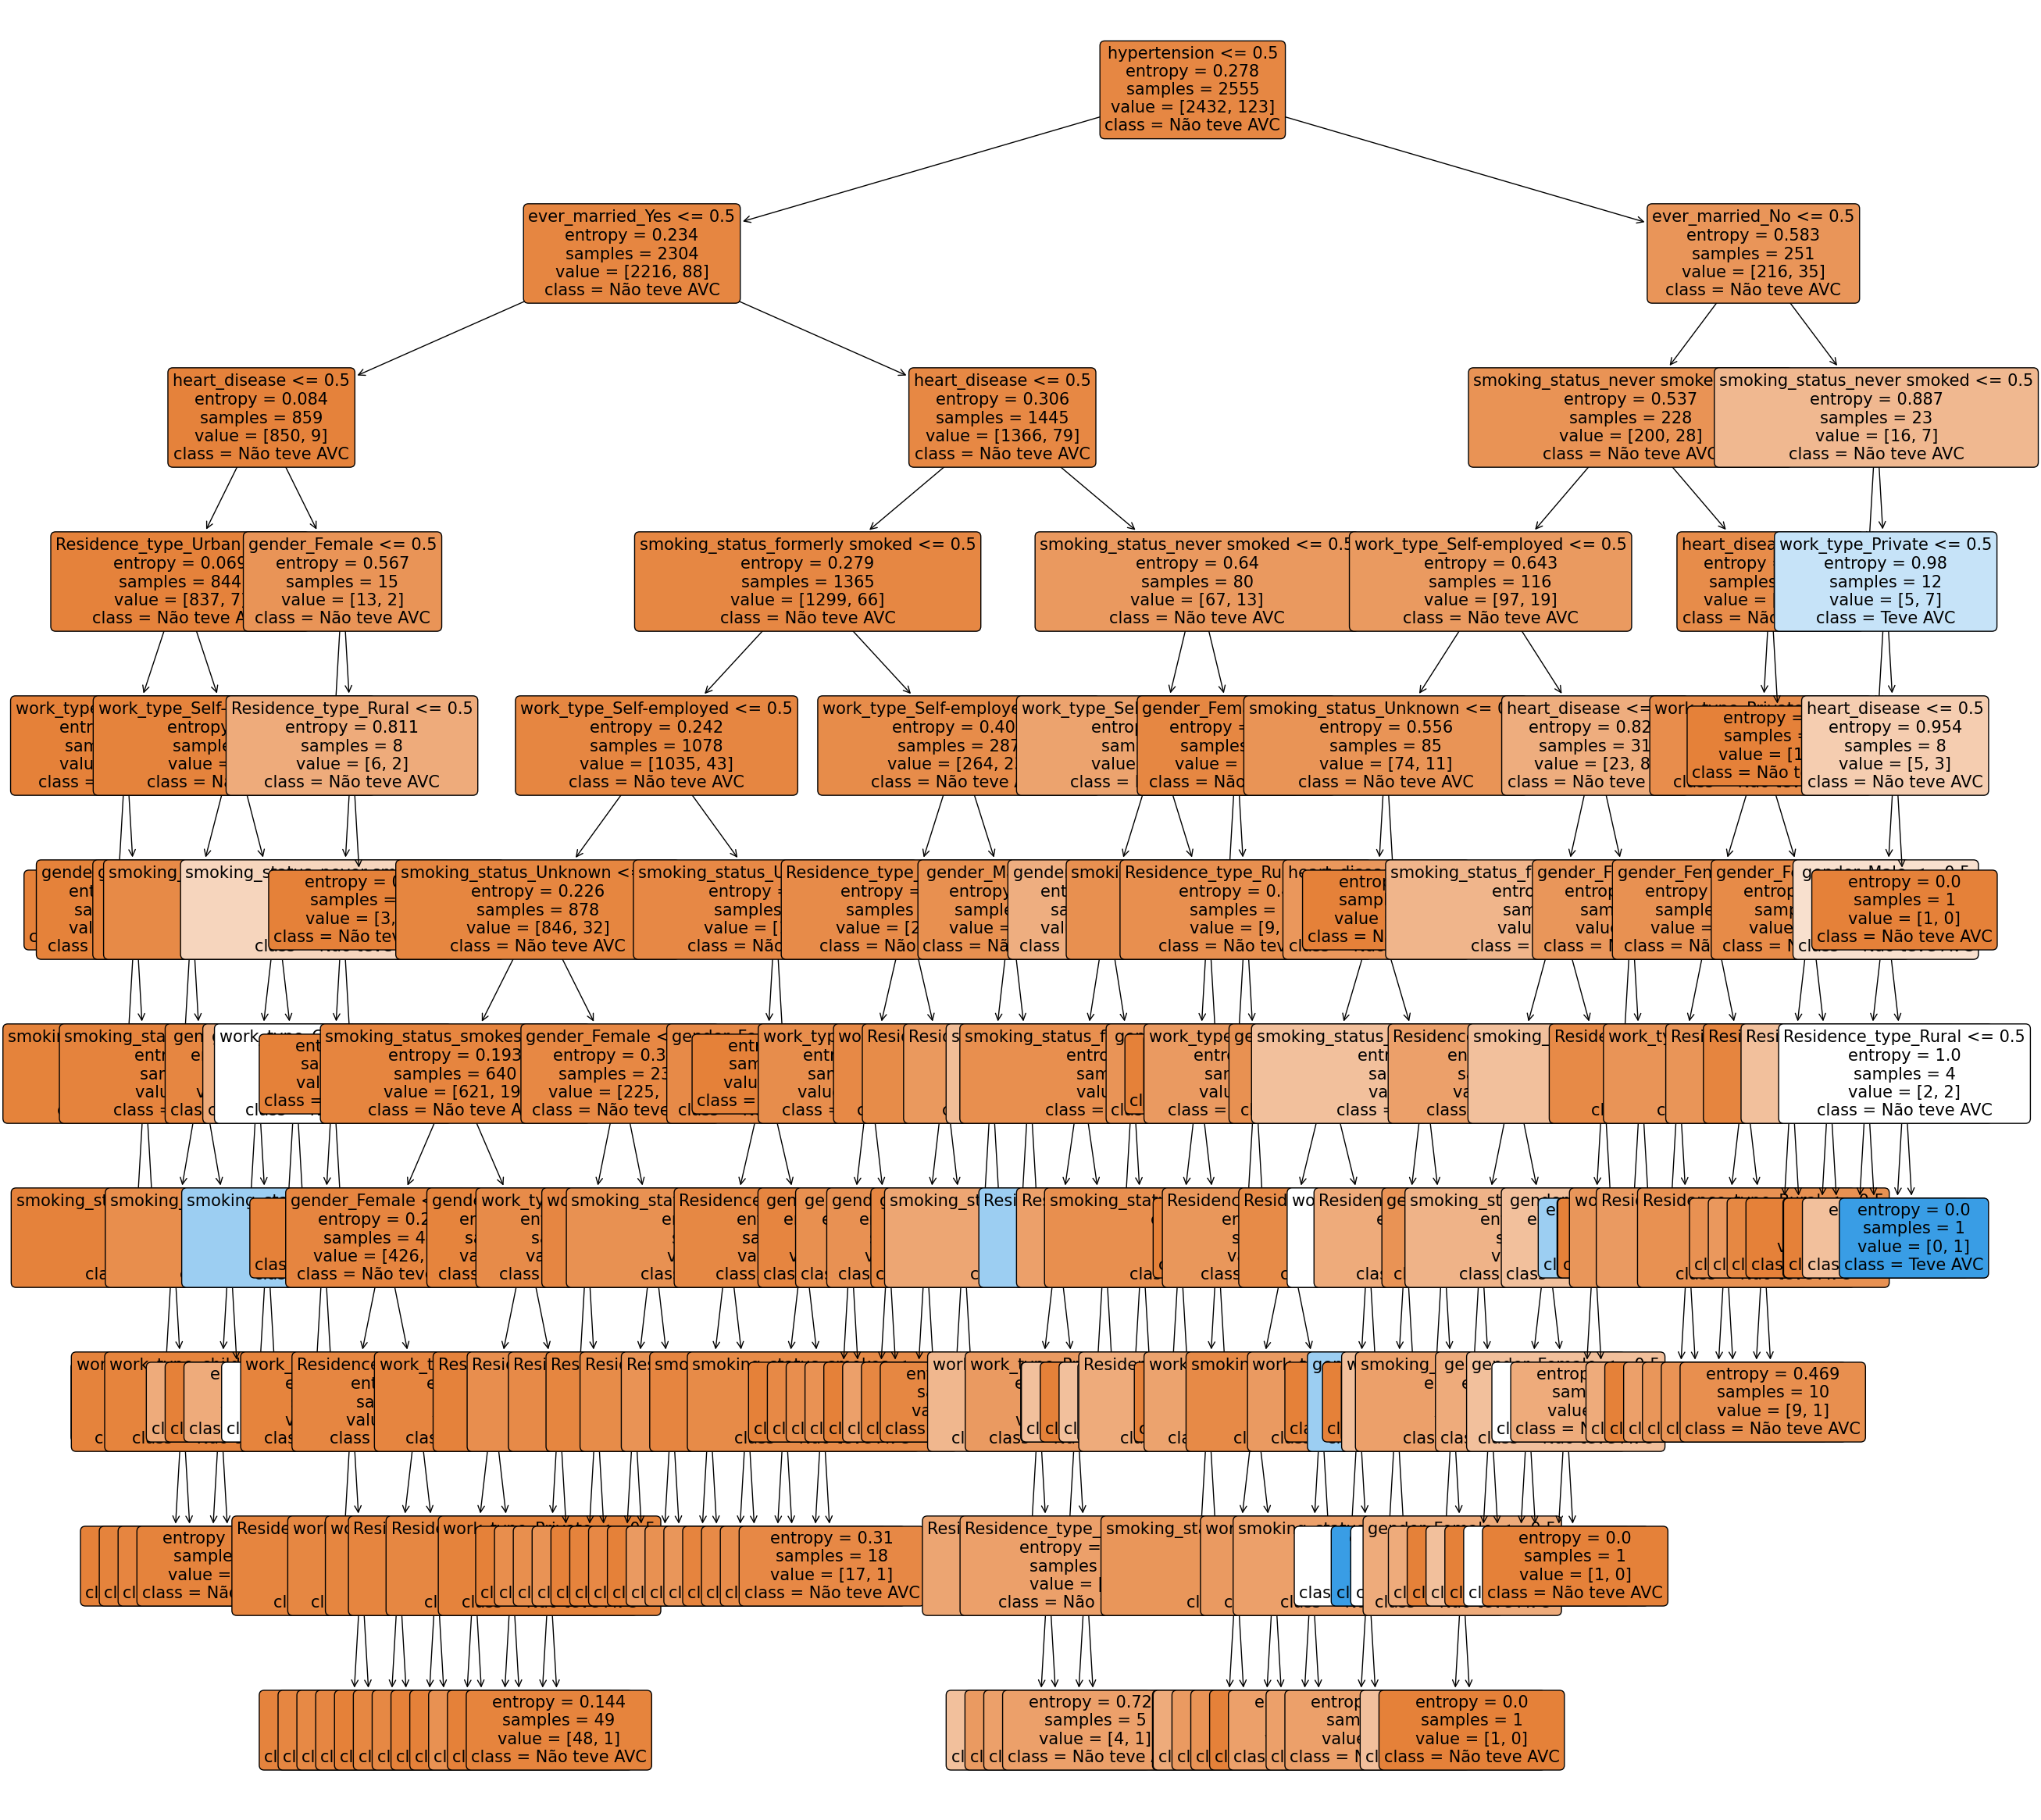

In [107]:
# Plotando a árvore de decisão
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plot_tree(classificador, filled=True, rounded=True, class_names=['Não teve AVC', 'Teve AVC'], feature_names=X_names, fontsize=15, node_ids=False)
plt.show()